Getting familiar with all CO and PPH data

In [1]:
import numpy as np
import geopandas as gp
import shapely as sp
import matplotlib.pyplot as plt
import contextily as cx
import cartopy as cp
from datetime import datetime as dt
from datetime import timedelta
import xarray as xr
import pandas as pd
import re
import os
from utils_filter import *
from utils_datetime import *

In [2]:
outlook_raw_location = 'raw_data/outlooks'
report_raw_location = 'raw_data/storm_reports'
pph_raw_location = 'raw_data/pph'
outlook_save_location = 'data/outlooks'
report_save_location = 'data/storm_reports'
pph_save_location = 'data/pph'

# Read in Convective outlooks and filter moderate days

In [3]:
# Read convective outlooks into outlooks
year_list = [[1987, 1991], [1992, 1999], [2000, 2007], [2008, 2015], [2016, 2023]]
for years, i in zip(year_list, range(len(year_list))):
    print('reading file ' + str(i) + ', years ' + str(years[0]) +'-' + str(years[1]))
    if i == 0:
        outlooks_original = gp.read_file(outlook_raw_location + '/outlooks_' + str(years[0]) + '01010000_' + str(years[1]) + '12312359')
    else:
        outlooks_original = outlooks_original.append(gp.read_file(outlook_raw_location + '/outlooks_' + str(years[0]) + '01010000_' + str(years[1]) + '12312359'))
print('files read')
    
outlooks_original



reading file 0, years 1987-1991
reading file 1, years 1992-1999


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\2443588550.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outlooks_original = outlooks_original.append(gp.read_file(outlook_raw_location + '/outlooks_' + str(years[0]) + '01010000_' + str(years[1]) + '12312359'))


reading file 2, years 2000-2007


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\2443588550.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outlooks_original = outlooks_original.append(gp.read_file(outlook_raw_location + '/outlooks_' + str(years[0]) + '01010000_' + str(years[1]) + '12312359'))


reading file 3, years 2008-2015


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\2443588550.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outlooks_original = outlooks_original.append(gp.read_file(outlook_raw_location + '/outlooks_' + str(years[0]) + '01010000_' + str(years[1]) + '12312359'))


reading file 4, years 2016-2023
files read


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\2443588550.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outlooks_original = outlooks_original.append(gp.read_file(outlook_raw_location + '/outlooks_' + str(years[0]) + '01010000_' + str(years[1]) + '12312359'))


,ISSUE,EXPIRE,PRODISS,TYPE,DAY,THRESHOLD,CATEGORY,CYCLE,geometry
0,198701011200,198701021200,198701010635,C,1,TSTM,CATEGORICAL,-1,"MULTIPOLYGON (((-80.69500 29.36500, -80.68200 ..."
1,198701011500,198701021200,198701011441,C,1,TSTM,CATEGORICAL,-1,"POLYGON ((-70.15100 42.90900, -70.14600 42.899..."
2,198701011900,198701021200,198701011849,C,1,TSTM,CATEGORICAL,-1,"POLYGON ((-73.73200 39.90700, -73.73200 39.892..."
3,198701021200,198701031200,198701020637,C,1,TSTM,CATEGORICAL,-1,"POLYGON ((-124.43300 41.91800, -124.44100 41.9..."
4,198701031200,198701041200,198701020725,C,2,None,None,-1,None
...,...,...,...,...,...,...,...,...,...
118483,202401021200,202401031200,202312310815,C,3,TSTM,CATEGORICAL,8,"POLYGON ((-90.74500 28.71100, -91.08300 28.732..."
118484,202312311300,202401011200,202312311236,C,1,None,None,13,None
118485,202312311630,202401011200,202312311558,C,1,None,None,16,None
118486,202401011200,202401021200,202312311712,C,2,None,None,17,None


In [4]:
# make dates datetime
outlooks = outlooks_original
outlooks['ISSUE'] = parse_datetime(outlooks['ISSUE'])
outlooks['EXPIRE'] = parse_datetime(outlooks['EXPIRE'])
outlooks['PRODISS'] = parse_datetime(outlooks['PRODISS'])

In [5]:
outlooks = fix_month_issue(outlooks)    

Fixing for 2002-03-03 12:00:00
Fixing for 2002-07-03 12:00:00
Fixing for 2002-08-03 12:00:00
Fixing for 2002-09-03 12:00:00
Fixing for 2003-05-03 12:00:00
Fixing for 2003-06-03 12:00:00
Fixing for 2003-07-03 12:00:00
Fixing for 2003-08-03 12:00:00
Fixing for 2003-10-03 12:00:00
Fixing for 2003-12-03 12:00:00
Fixing for 2004-01-03 12:00:00
Fixing for 2004-02-03 12:00:00
Fixing for 2004-03-03 12:00:00
Fixing for 2004-04-03 12:00:00
Fixing for 2004-05-03 12:00:00
Fixing for 2004-06-03 12:00:00
Fixing for 2004-07-03 12:00:00
Fixing for 2004-09-03 12:00:00
Fixing for 2004-10-03 12:00:00
Fixing for 2005-04-03 12:00:00
Fixing for 2005-05-03 12:00:00
Fixing for 2005-06-03 12:00:00
Fixing for 2005-07-03 12:00:00
Fixing for 2005-08-03 12:00:00
Fixing for 2005-09-03 12:00:00
Fixing for 2005-12-03 12:00:00
Fixing for 2006-01-03 12:00:00
Fixing for 2006-03-03 12:00:00
Fixing for 2006-04-03 12:00:00
Fixing for 2006-05-03 12:00:00
Fixing for 2006-06-03 12:00:00
Fixing for 2006-07-03 12:00:00
Fixing f

In [6]:
# add column with just valid date
outlooks['DATE'] = create_dates(outlooks['EXPIRE'], -1)

# identify dates with MDT
mod_dates = identify_dates_above_threshold(outlooks, 'MDT')

(array([36., 40., 67., 75., 64., 70., 73., 57., 82., 71., 59., 64., 55.,
        65., 58., 61., 60., 46., 53., 48., 33., 53., 32., 29., 38., 23.,
        22., 20., 13., 12., 18., 13., 14., 10., 14., 27.]),
 array([1987., 1988., 1989., 1990., 1991., 1992., 1993., 1994., 1995.,
        1996., 1997., 1998., 1999., 2000., 2001., 2002., 2003., 2004.,
        2005., 2006., 2007., 2008., 2009., 2010., 2011., 2012., 2013.,
        2014., 2015., 2016., 2017., 2018., 2019., 2020., 2021., 2022.,
        2023.]),
 <BarContainer object of 36 artists>)

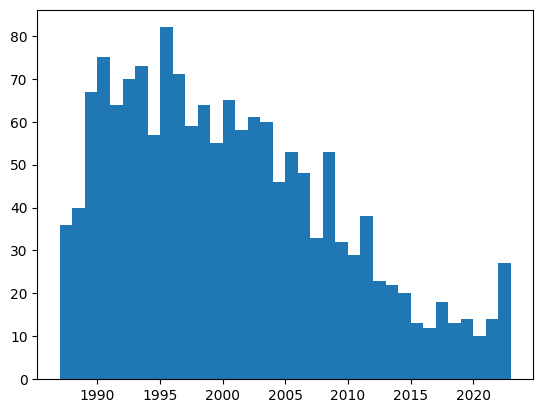

In [7]:
# Plot number of MDT days by year
years_of_mdt = get_years(mod_dates)
plt.hist(years_of_mdt, bins=range(min(years_of_mdt), max(years_of_mdt) + 1, 1))

In [8]:
# dataframe containing only outlooks for days in which there was a MDT risk
mdt_outlooks = outlooks[outlooks['DATE'].isin(mod_dates)]

# convert datetimes back to strings
outlooks = revert_all_datetimes(outlooks)
mdt_outlooks = revert_all_datetimes(mdt_outlooks)

# save dataframes
outlooks.iloc[:int(len(outlooks)/2)].to_file(outlook_save_location + '/all_outlooks_1.shp')
outlooks.iloc[int(len(outlooks)/2)+1:].to_file(outlook_save_location + '/all_outlooks_2.shp')
mdt_outlooks.to_file(outlook_save_location + '/mdt_outlooks.shp')


C:\Users\miles\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# Now read, combine, filter (to mdt), and save PPH data

In [9]:
hazard_types = ['wind', 'sig_wind', 'hail', 'sig_hail', 'tor', 'sig_tor']
for hazard, i in zip(hazard_types, range(len(hazard_types))):
    print('reading in ' + hazard + ' pph')
    if i == 0:
        pph_data = xr.open_dataset(pph_raw_location + '/pper_' + hazard + '_1979_2019.nc')
    else:
        new_data = xr.open_dataset(pph_raw_location + '/pper_' + hazard + '_1979_2019.nc')
        pph_data = xr.merge([pph_data, new_data])




reading in wind pph
reading in sig_wind pph
reading in hail pph
reading in sig_hail pph
reading in tor pph
reading in sig_tor pph


In [10]:
# select pph data on days with mdt risk
pph_data_mod = pph_data.sel(time=pph_data.time.dt.date.isin(mod_dates.tolist()))

In [12]:
# save full and moderate pph datasets
pph_data.to_netcdf(pph_save_location + '/all_pph.nc')
pph_data_mod.to_netcdf(pph_save_location + '/mdt_pph.nc')

# Read in, combine, filter, and save raw storm reports

In [13]:
columns =['STATE', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_NAME', 'CZ_NAME', 'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME', 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE', 'MAGNITUDE', 'MAGNITUDE_TYPE', 'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH', 'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON']
event_types = ['Funnel Cloud', 'Hail', 'Marine Hail', 'Marine Thunderstorm Wind', 'Thunderstorm Wind', 'Tornado', 'Waterspout']




In [14]:
# read in reports and combine into all_reports
first = True
for file in os.listdir(os.fsencode(report_raw_location)):
    filename = os.fsdecode(file)
    if 'StormEvents_details-ftp_v1.0_d' in filename:
        print('reading' + filename)
        reports = gp.read_file(report_raw_location + '/' + filename)
        if first:
            all_reports = filter_reports(reports, columns, event_types)
            first = False
        else:
            all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1950_c20210803.csv
readingStormEvents_details-ftp_v1.0_d1951_c20210803.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))
C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1952_c20210803.csv
readingStormEvents_details-ftp_v1.0_d1953_c20210803.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1954_c20210803.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1955_c20210803.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1956_c20210803.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1957_c20210803.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1958_c20210803.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1959_c20210803.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1960_c20210803.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1961_c20210803.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1962_c20210803.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1963_c20210803.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1964_c20210803.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1965_c20210803.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1966_c20210803.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1967_c20210803.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1968_c20210803.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1969_c20210803.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1970_c20210803.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1971_c20210803.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1972_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1973_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1974_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1975_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1976_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1977_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1978_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1979_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1980_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1981_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1982_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1983_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1984_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1985_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1986_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1987_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1988_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1989_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1990_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1991_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1992_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1993_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1994_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1995_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1996_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1997_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1998_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d1999_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d2000_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d2001_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d2002_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d2003_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d2004_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d2005_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d2006_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d2007_c20240216.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d2008_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d2009_c20231116.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d2010_c20220425.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d2011_c20230417.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d2012_c20221216.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


readingStormEvents_details-ftp_v1.0_d2013_c20230118.csv


C:\Users\miles\AppData\Local\Temp\ipykernel_31608\957715867.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_reports = all_reports.append(filter_reports(reports, columns, event_types))


In [ ]:
# filter all_reports to get all_reports_mdt
all_reports['DATE'] = parse_datetime_reports(all_reports['BEGIN_DATE_TIME'])
all_reports_mdt = all_reports[all_reports['DATE'].isin(mod_dates.tolist())]



In [ ]:
# save report data
all_reports.to_csv(report_save_location + '/all_reports.csv')
all_reports_mdt.to_csv(report_save_location + '/mdt_reports.csv')


In [ ]:
outlooks[outlooks['DATE'] == 201804020000]